# **Import Libraries**

In [1]:
import itertools
import warnings
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 500)
pd.set_option("display.float_format", lambda x: "%.4f" % x)

import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt

warnings.filterwarnings("ignore")

# **Now we will Import Dataset**

In [2]:
df = pd.read_csv("AirPassengers[1].csv", index_col='Month', parse_dates=True)
df.rename({'#Passengers': 'Passengers'}, axis=1, inplace=True)
df.index.freq = 'MS'
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


General Information about the Dataset

In [3]:
def check_df(dataframe,head=5):
  print("######################### Head #########################")
  print(dataframe.head(head))
  print("######################### Tail #########################")
  print(dataframe.tail(head))
  print("######################### Shape #########################")
  print(dataframe.shape)
  print("######################### Types #########################")
  print(dataframe.dtypes)
  print("######################### NA #########################")
  print(dataframe.isnull().sum())
  print("######################### Qurtiles #########################")
  print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [4]:
check_df(df)

######################### Head #########################
            Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121
######################### Tail #########################
            Passengers
Month                 
1960-08-01         606
1960-09-01         508
1960-10-01         461
1960-11-01         390
1960-12-01         432
######################### Shape #########################
(144, 1)
######################### Types #########################
Passengers    int64
dtype: object
######################### NA #########################
Passengers    0
dtype: int64
######################### Qurtiles #########################
              count     mean      std      min       0%       5%      50%      95%      99%     100%      max
Passengers 144.0000 280.2986 119.9663 104.0000 104.0000 121.6000 265.5000 488.1500 585.7900 622.0000 622.0000


# **We will Visualize the time Series**

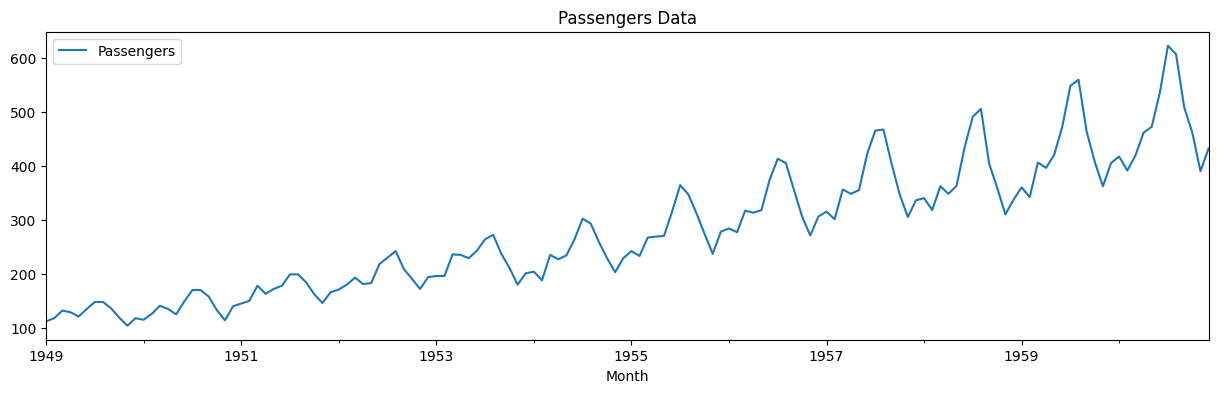

In [5]:
df[['Passengers']].plot(figsize=(15,4), title='Passengers Data')
plt.show()

# **Now we will Split the Dataest**

In [6]:
train = df[:120]
test = df[120:]
print((len(train), len(test)))

(120, 24)


# **Time Series Structural Analysis**

In [7]:
def ts_decompose(y, model="additive"):
    
    # Stationary Test: Dickey-Fuller
    # "HO: Non-stationary"
    # "H1: Stationary"
    p_value = sm.tsa.stattools.adfuller(y)[1]
    if p_value < 0.05:
        is_istationary = (F"Result: Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")
    else:
        is_istationary = (F"Result: Non-Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")
    
    result = seasonal_decompose(y, model=model)
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    axes[0].set_title("Decomposition for " + model + " model")
    axes[0].plot(y, 'k', label='Original ' + model)
    axes[0].legend(loc='upper left')

    axes[1].set_title(is_istationary)
    axes[1].plot(result.trend, label='Trend')
    axes[1].legend(loc='upper left')

    axes[2].plot(result.seasonal, 'g', label='Seasonality & Mean: ' + str(round(result.seasonal.mean(), 4)))
    axes[2].legend(loc='upper left')

    axes[3].plot(result.resid, 'r', label='Residuals & Mean: ' + str(round(result.resid.mean(), 4)))
    axes[3].legend(loc='upper left')
    plt.show(block=True)

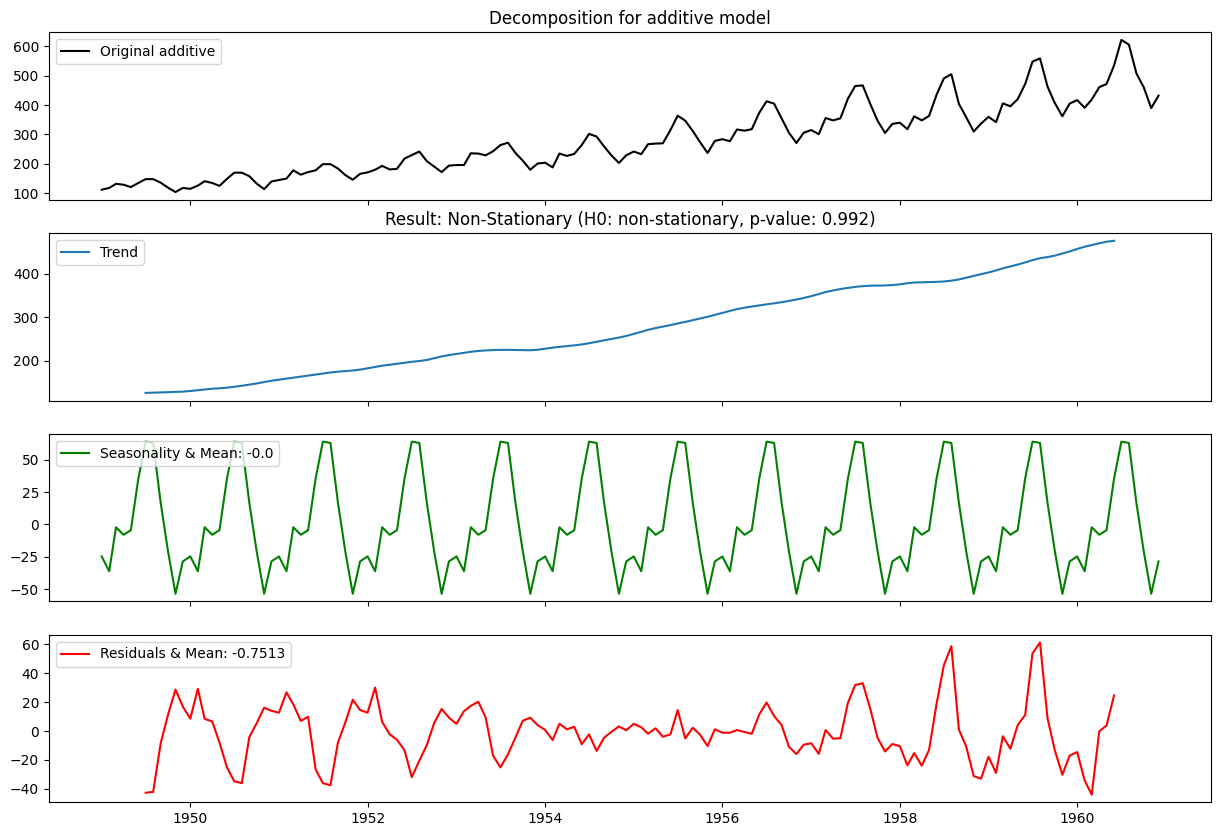

In [8]:
ts_decompose(df)

# **SES: Single Exponential Smoothing**

📌 Single Exponential Smoothing, SES for short, also called Simple Exponential Smoothing, is a time series forecasting method for univariate data without a trend or seasonality.

📌 It requires a single parameter, called alpha (a), also called the smoothing factor or smoothing coefficient.

📌 This parameter controls the rate at which the influence of the observations at prior time steps decay exponentially. Alpha is often set to a value between 0 and 1. Large values mean that the model pays attention mainly to the most recent past observations, whereas smaller values mean more of the history is taken into account when making a prediction.

In [9]:
def plot_model(train, test, y_pred, title):
  mae = mean_absolute_error(test, y_pred)
  train["Passengers"].plot(figsize=(15, 4), legend=True, label="TRAIN", title=f"{title}, MAE: {round(mae, 2)}")
  test["Passengers"].plot(legend=True, label="TEST")
  y_pred.plot(legend=True, label="PREDICTION")
  plt.show()

In [10]:
def ses_optimizer(train, alphas, step):

    best_alpha, best_mae = None, float("inf")

    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha)
        y_pred = ses_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)

        if mae < best_mae:
            best_alpha, best_mae = alpha, mae

    return best_alpha, best_mae

In [11]:
def ses_model_tuning(train , test, step, title="Model Tuning - Single Exponential Smoothing"):
  alphas = np.arange(0.01, 1, 0.1)
  best_alpha, best_mae = ses_optimizer(train, alphas, step=step)
  final_model = SimpleExpSmoothing(train).fit(smoothing_level=best_alpha)
  y_pred = final_model.forecast(step)
  mae = mean_absolute_error(test, y_pred)
  plot_model(train, test, y_pred, title)

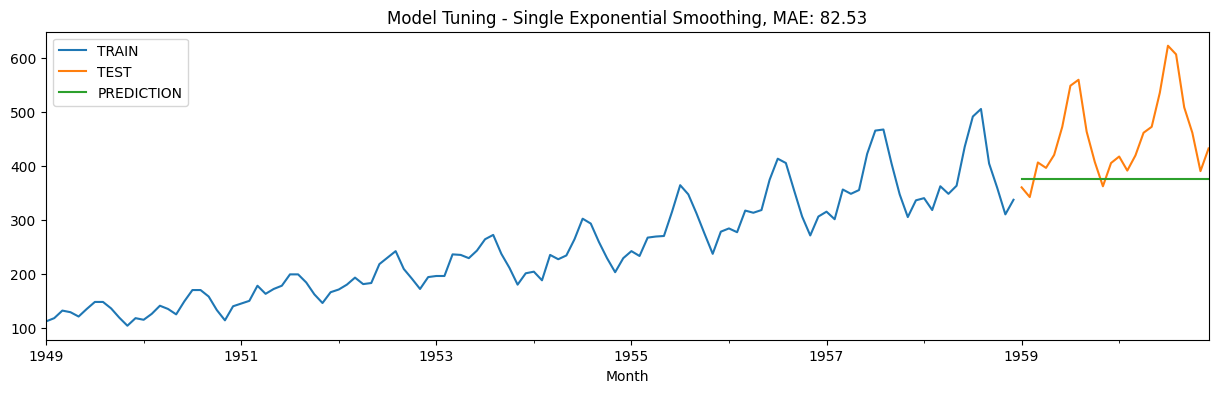

In [12]:
ses_model_tuning(train, test, step=24)